In [58]:
import pandas as pd
pd.set_option('max_colwidth', 1000)
import torch

import importlib
import data_preprocess_stance, train_stance, eval_stance  # after renaming file to evaluation_utils.py
importlib.reload(data_preprocess_stance)
importlib.reload(train_stance)
importlib.reload(eval_stance)

from data_preprocess_stance import  preprocess_data
from train_stance import  train_model, load_stance_model
from eval_stance import plot_training_history_cm_cr, load_training_results


In [59]:
dfMT1 = pd.read_json("../data/dfMT1_stance-v1.json") #1
dfMT2 = pd.read_json("../data/dfMT2_stance-v1.json") #2
dfIBM = pd.read_json("../data/dfIBM_stance-v1.json") #3
dfPC = pd.read_json("../data/dfPE_stance-v1.json") #4
dfUKB = pd.read_json("../data/dfUKB_stance-v2.json") #5

# MT1

In [55]:
dfMT1.head(670)

,EDU,stance,topic_id,Relations,Label,all_stance
0,"[Yes, it's annoying and cumbersome to separate your rubbish properly all the time., Three different bin bags stink away in the kitchen and have to be sorted into different wheelie bins., But still Germany produces way too much rubbish, and too many resources are lost when what actually should be separated and recycled is burnt., We Berliners should take the chance and become pioneers in waste separation!]","[Against, Against, For, For, For]",waste_separation,"[[a1, a5, reb], [a2, a1, sup], [a3, c1, und], [a4, c3, add]]","[0, 0, 0, 0, 1]",pro
1,"[One can hardly move in Friedrichshain or Neukölln these days without permanently scanning the ground for dog dirt., And when bad luck does strike and you step into one of the many 'land mines' you have to painstakingly scrape the remains off your soles., Higher fines are therefore the right measure against negligent, lazy or simply thoughtless dog owners., Of course, first they'd actually need to be caught in the act by public order officers,, but once they have to dig into their pockets, their laziness will sure vanish!]","[For, For, For, Against, For]",higher_dog_poo_fines,"[[a1, a3, sup], [a2, a3, sup], [a4, a3, reb], [a5, c4, und]]","[0, 0, 1, 0, 0]",pro
2,"[Health insurance companies should not cover treatment in complementary medicine, unless the promised effect and its medical benefit have been concretely proven., Yet this very proof is lacking in most cases., Patients do often report relief of their complaints after such treatments., But as long as it is unclear as to how this works, the funds should rather be spent on therapies where one knows with certainty.]","[For, Against, For, Against, For]",health_insurance_cover_complementary_medicine,"[[a2, a1, reb], [a3, a2, reb], [a4, a1, reb], [a5, c4, und]]","[1, 0, 0, 0, 0]",con
3,"[Of course there are a number of programmes in public broadcasting that are not worth the licencing fee,, and others, such as “Musikantenstadl” and soap operas, are only interesting to certain audiences., Nevertheless, everybody should contribute to the funding of the public broadcasters in equal measure,, for we need general and independent media., After all we want to get our view of the world neither through the lens of the government nor through that of rich media entrepreneurs.]","[Against, Against, For, For, For]",public_broadcasting_fees_on_demand,"[[a1, a3, reb], [a2, a3, reb], [a4, a3, sup], [a5, a4, sup]]","[0, 0, 1, 0, 0]",con
4,"[Intelligence services must urgently be regulated more tightly by parliament;, this should be clear to everyone after the disclosures of Edward Snowden., Granted, those concern primarily the British and American intelligence services,, but the German services evidently do collaborate with them closely., Their tools, data and expertise have been used to keep us under surveillance for a long time.]","[For, For, Against, For, For]",stricter_regulation_of_intelligence_services,"[[a2, a1, sup], [a3, c2, und], [a4, c3, und], [a5, a4, sup]]","[1, 0, 0, 0, 0]",pro
...,...,...,...,...,...,...
107,"[Dog owners should pay higher fines for dog dirt left on pavements,, although there aren't enough bins and bag-dispensers for dog dirt., One reason for this is that they have thus far hardly had to fear the consequences despite the obligation to clean up., A higher fine, so dog owners would have to dig deeper into their pockets, is supposed to be a deterrent after all., The city, especially the green spaces, should be kept tidy after all,, for they are there for our recreation., Besides you're not allowed to leave other rubbish without punishment.]","[For, Against, For, For, For, For, For]",higher_dog_poo_fines,"[[a2, a1, reb], [a3, a1, sup], [a4, a1, sup], [a5, a1, sup], [a6, a5, sup], [a7, a1, sup]]","[1, 0, 0, 0, 0, 0, 0]",pro
108,"[Capital punishment is not a solution,, as it cannot be ruled out that the judicial process may make mistakes., Criminals should not be put in luxury 

### With Sampling
here, we keep the order of adu, feed to model row by row

In [28]:
X_train, X_test, y_train, y_test = preprocess_data(dfMT1, use_nrc=True, include_topic=True, sample_level= True, test_size=0.2,random_state=41,)

### With No Sampling (N)
here, we do not keep the order of adu, feed to model each adu

In [60]:
X_train_n, X_test_n, y_train_n, y_test_n = preprocess_data(dfMT1, use_nrc=True, include_topic=True, sample_level= False, test_size=0.2,random_state=41,)

# Train Stance  Classifier (N)

In [ ]:
model_n, history_n, y_test_pred_n = train_model(
    X_train=(X_train_n['text'].tolist(), X_train_n['topic_id'].tolist()),
    y_train=y_train_n.tolist(),
    X_test=(X_test_n['text'].tolist(), X_test_n['topic_id'].tolist()),
    y_test=y_test_n.tolist(),
    batch_size=4,
    epochs=2,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=False,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='./models/Bert_stance_MT1_B4_E2.pt'
    )




h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model architecture:
StanceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

Epoch 1/2:  55%|█████▍    | 63/115 [05:06<04:55,  5.67s/it]

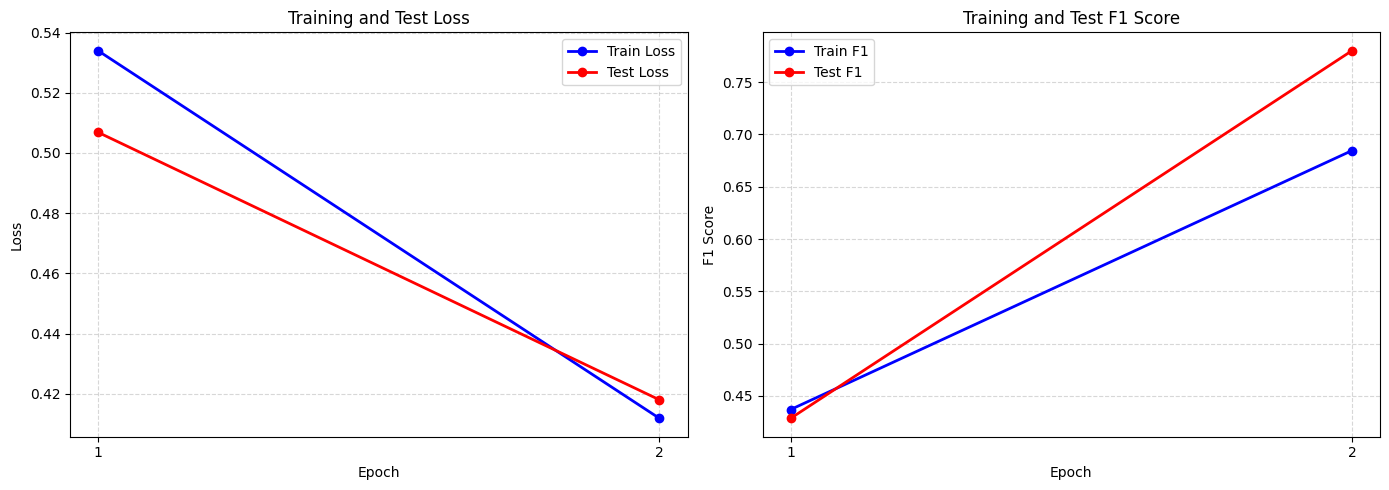

✅ Chart saved as ./models/Bert_stance_MT1_B4_E2.pt_charts.png

Confusion Matrix:
[[16 13]
 [ 4 83]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.55      0.65        29
           1       0.86      0.95      0.91        87

    accuracy                           0.85       116
   macro avg       0.83      0.75      0.78       116
weighted avg       0.85      0.85      0.84       116

✅ Evaluation report saved as ./models/Bert_stance_MT1_B4_E2.pt_eval.txt


In [41]:
plot_training_history_cm_cr(history_n, y_true=y_test_n, y_pred=y_test_pred_n, run_name="./models/Bert_stance_MT1_B4_E2.pt")


# Test Reproducabilty of  the results

In [51]:
history_n, y_test_n, y_test_pred_n = load_training_results("./models/Bert_stance_MT1_B4_E2.pt")




h:\moha\NLP\AM\SA\ArguSentiment\src\eval_stance.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location="cpu")  # or "cuda" if needed

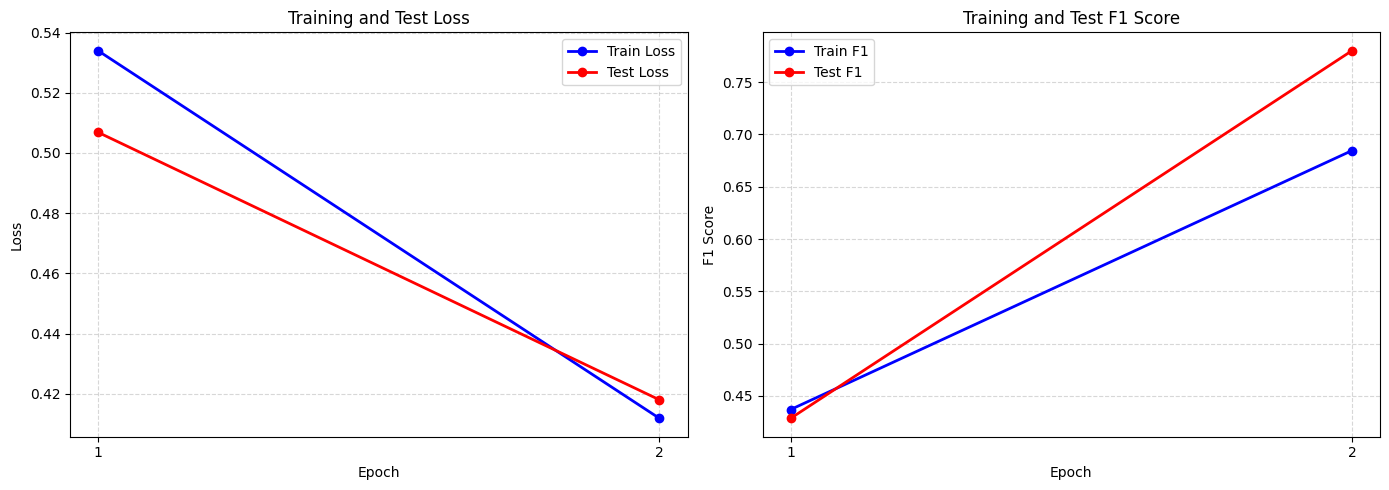

✅ Chart saved as ./models/Bert_stance_MT1_B4_E2_charts.png

Confusion Matrix:
[[16 13]
 [ 4 83]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.55      0.65        29
           1       0.86      0.95      0.91        87

    accuracy                           0.85       116
   macro avg       0.83      0.75      0.78       116
weighted avg       0.85      0.85      0.84       116

✅ Evaluation report saved as ./models/Bert_stance_MT1_B4_E2_eval.txt


In [52]:
plot_training_history_cm_cr(
    history_n,
    y_true=y_test_n,
    y_pred=y_test_pred_n,
    run_name="./models/Bert_stance_MT1_B4_E2"
)

In [57]:
model = torch.load("./models/Bert_stance_MT1_B4_E2.pt")
print(model)

C:\Users\moha\AppData\Local\Temp\ipykernel_16592\3307508129.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("./models/Bert_stance_MT1_B4_E2.pt")


{'model_state_dict': OrderedDict([('bert.embeddings.word_embeddings.weight', tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098],
        [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
        [-0.0198, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
        ...,
        [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
        [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
        [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]])), ('bert.embeddings.position_embeddings.weight', tensor([[ 0.0172, -0.0253, -0.0368,  ..., -0.0003,  0.0005,  0.0152],
        [ 0.0074,  0.0022, -0.0196,  ...,  0.0293,  0.0303, -0.0052],
        [-0.0115, -0.0023, -0.0121,  ...,  0.0151,  0.0184, -0.0072],
        ...,
        [ 0.0174,  0.0035, -0.0096,  ...,  0.0030,  0.0004, -0.0269],
        [ 0.0217, -0.0060,  0.0147,  ..., -0.0056, -0.0126, -0.0281],
        [ 0.0026, -0.0233,  0.0055,  ...,  0.0175,  0.0275, -0.0777]])), ('be

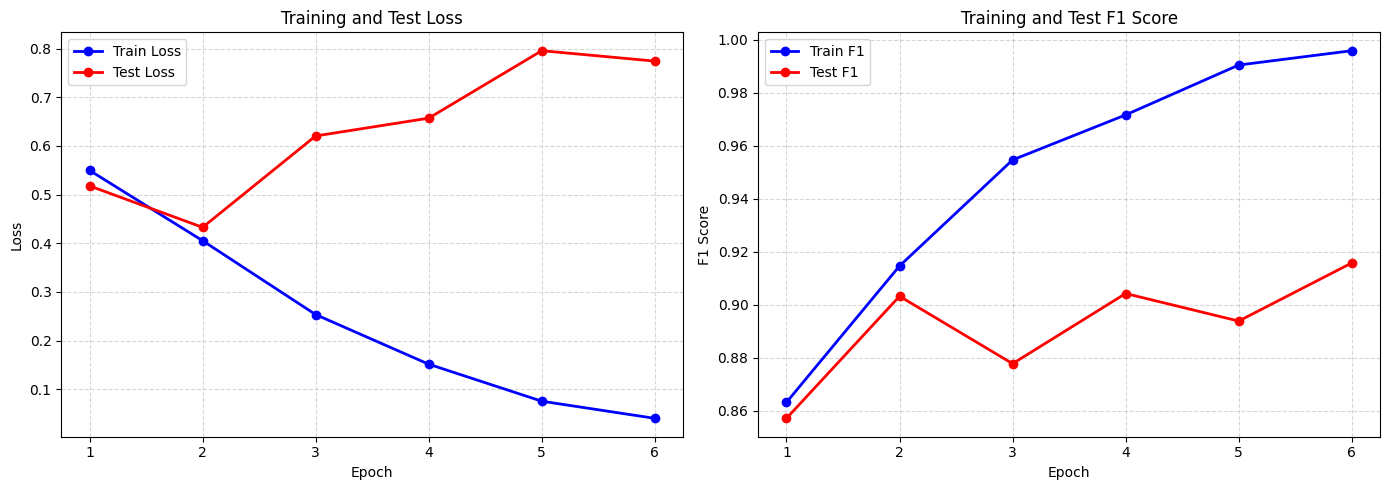

✅ Chart saved as ./plots/MT1_Bert_E2_B4_N_charts.png

Confusion Matrix:
[[13 16]
 [ 0 87]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.45      0.62        29
           1       0.84      1.00      0.92        87

    accuracy                           0.86       116
   macro avg       0.92      0.72      0.77       116
weighted avg       0.88      0.86      0.84       116

✅ Evaluation report saved as ./plots/MT1_Bert_E2_B4_N_eval.txt


In [17]:
plot_training_history_cm_cr(history_n, y_true=y_test_n, y_pred=y_test_pred_n, run_name="./plots/MT1_Bert_E2_B4_N")


# Train Stance  Classifier 

In [ ]:
model, history, y_test_pred= train_model(
    X_train=(X_train['text'].tolist(), X_train['topic_id'].tolist(), X_train['nrc_feats'].tolist()),
    y_train=y_train.tolist(),
    X_test=(X_test['text'].tolist(), X_test['topic_id'].tolist(), X_test['nrc_feats'].tolist()),
    y_test=y_test.tolist(),
    batch_size=4,
    epochs=6,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=True,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='stance_model_sampleMT1_Bert_E6_B4.pt'
)


h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/6: 100%|██████████| 115/115 [04:01<00:00,  2.10s/it]


Epoch 1/6
Train loss: 0.5060
Train F1: 0.8673
Test loss: 0.4783
Test F1: 0.9038, Precision: 0.8246, Recall: 1.0000
--------------------------------------------------


Epoch 2/6: 100%|██████████| 115/115 [03:58<00:00,  2.08s/it]


Epoch 2/6
Train loss: 0.4846
Train F1: 0.9005
Test loss: 0.5750
Test F1: 0.8900, Precision: 0.8396, Recall: 0.9468
--------------------------------------------------


Epoch 3/6: 100%|██████████| 115/115 [04:00<00:00,  2.09s/it]


Epoch 3/6
Train loss: 0.3872
Train F1: 0.9296
Test loss: 0.6401
Test F1: 0.8587, Precision: 0.8778, Recall: 0.8404
--------------------------------------------------


Epoch 4/6: 100%|██████████| 115/115 [03:58<00:00,  2.07s/it]


Epoch 4/6
Train loss: 0.2273
Train F1: 0.9574
Test loss: 0.6745
Test F1: 0.8783, Precision: 0.8737, Recall: 0.8830
--------------------------------------------------


Epoch 5/6: 100%|██████████| 115/115 [03:57<00:00,  2.07s/it]


Epoch 5/6
Train loss: 0.1083
Train F1: 0.9847
Test loss: 0.6966
Test F1: 0.9216, Precision: 0.8545, Recall: 1.0000
--------------------------------------------------


Epoch 6/6: 100%|██████████| 115/115 [04:04<00:00,  2.12s/it]


Epoch 6/6
Train loss: 0.0514
Train F1: 0.9944
Test loss: 0.8592
Test F1: 0.8969, Precision: 0.8700, Recall: 0.9255
--------------------------------------------------
✅ Model saved to: stance_model_sampleMT1_Bert_E6_B4_N.pt


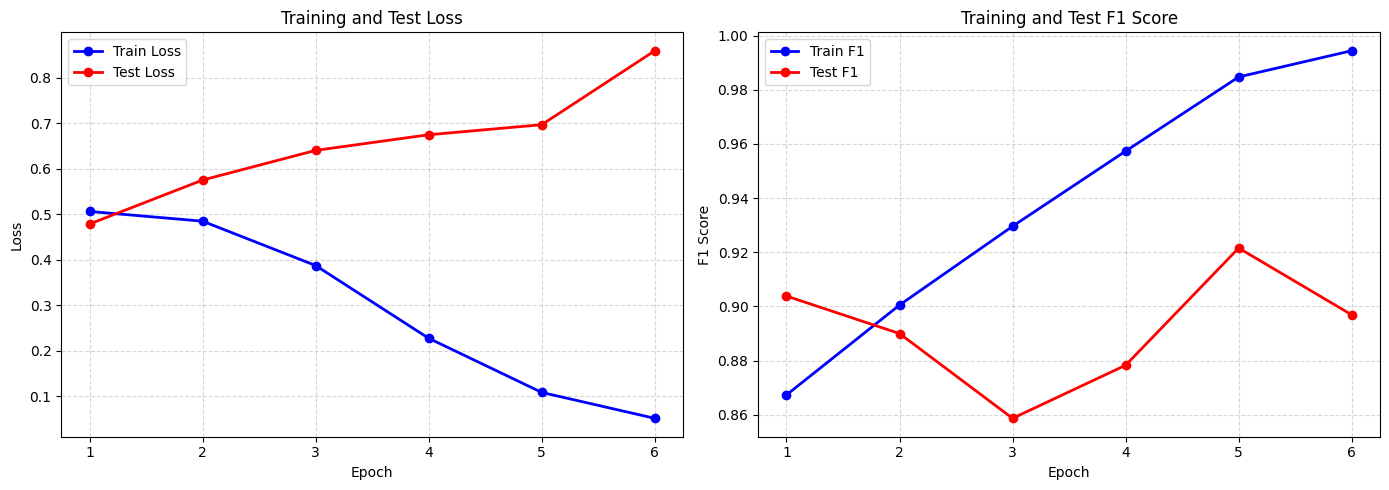

✅ Chart saved as stance_model_MT1_Bert_E6_B4.pt_charts.png

Confusion Matrix:
[[12 13]
 [ 7 87]]

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.48      0.55        25
           1       0.87      0.93      0.90        94

    accuracy                           0.83       119
   macro avg       0.75      0.70      0.72       119
weighted avg       0.82      0.83      0.82       119

✅ Evaluation report saved as stance_model_MT1_Bert_E6_B4.pt_eval.txt


In [20]:
plot_training_history_cm_cr(history,y_true=y_test,y_pred=y_test_pred, classes=["0", "1"], run_name='stance_model_MT1_Bert_E6_B4.pt')


# MT2

In [21]:
X_train2, X_test2, y_train2, y_test2 = preprocess_data(dfMT2, use_nrc=True, include_topic=True, sample_level= True, test_size=0.2,random_state=41,)

In [22]:
X_train2_n, X_test2_n, y_train2_n, y_test2_n = preprocess_data(dfMT2, use_nrc=True, include_topic=True, sample_level= False, test_size=0.2,random_state=41,)

In [23]:
model2_n, history2_n, y_test2_pred_n = train_model(
    X_train=(X_train2_n['text'].tolist(), X_train2_n['topic_id'].tolist()),
    y_train=y_train2_n.tolist(),
    X_test=(X_test2_n['text'].tolist(), X_test2_n['topic_id'].tolist()),
    y_test=y_test2_n.tolist(),
    batch_size=4,
    epochs=6,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=False,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='./models/stance_model_MT2_Bert_E6_B4_N.pt'
    )




h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/6: 100%|██████████| 160/160 [05:26<00:00,  2.04s/it]


Epoch 1/6
Train loss: 0.4434
Train F1: 0.9096
Test loss: 0.4323
Test F1: 0.9333, Precision: 0.8750, Recall: 1.0000
--------------------------------------------------


Epoch 2/6: 100%|██████████| 160/160 [05:25<00:00,  2.04s/it]


Epoch 2/6
Train loss: 0.3960
Train F1: 0.9354
Test loss: 0.5042
Test F1: 0.9046, Precision: 0.8951, Recall: 0.9143
--------------------------------------------------


Epoch 3/6: 100%|██████████| 160/160 [05:19<00:00,  2.00s/it]


Epoch 3/6
Train loss: 0.3204
Train F1: 0.9515
Test loss: 0.5176
Test F1: 0.8905, Precision: 0.9104, Recall: 0.8714
--------------------------------------------------


Epoch 4/6: 100%|██████████| 160/160 [05:18<00:00,  1.99s/it]


Epoch 4/6
Train loss: 0.2241
Train F1: 0.9688
Test loss: 0.6382
Test F1: 0.9172, Precision: 0.8867, Recall: 0.9500
--------------------------------------------------


Epoch 5/6: 100%|██████████| 160/160 [05:18<00:00,  1.99s/it]


Epoch 5/6
Train loss: 0.1157
Train F1: 0.9856
Test loss: 0.7390
Test F1: 0.9149, Precision: 0.9085, Recall: 0.9214
--------------------------------------------------


Epoch 6/6: 100%|██████████| 160/160 [05:18<00:00,  1.99s/it]


Epoch 6/6
Train loss: 0.1005
Train F1: 0.9883
Test loss: 0.7485
Test F1: 0.9135, Precision: 0.8859, Recall: 0.9429
--------------------------------------------------
✅ Model saved to: ./models/stance_model_MT2_Bert_E6_B4_N.pt


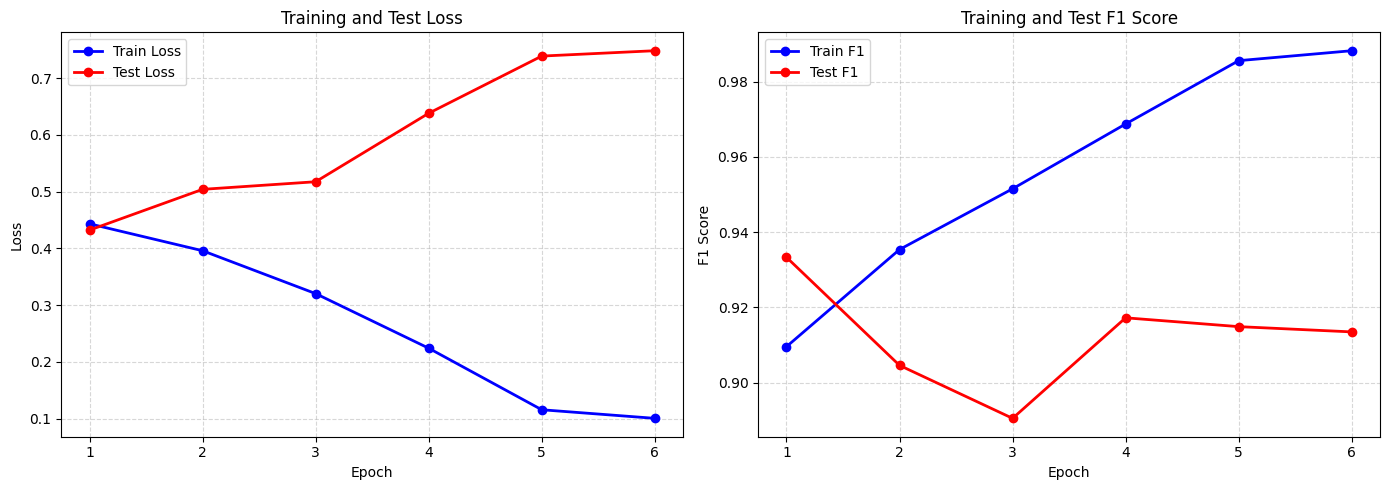

✅ Chart saved as ./plots/MT2_Bert_E2_B6_N_charts.png

Confusion Matrix:
[[  3  17]
 [  8 132]]

Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.15      0.19        20
           1       0.89      0.94      0.91       140

    accuracy                           0.84       160
   macro avg       0.58      0.55      0.55       160
weighted avg       0.81      0.84      0.82       160

✅ Evaluation report saved as ./plots/MT2_Bert_E2_B6_N_eval.txt


In [24]:
plot_training_history_cm_cr(history2_n, y_true=y_test2_n, y_pred=y_test2_pred_n, run_name="./plots/MT2_Bert_E2_B6_N")


In [28]:
model2, history2, y_test2_pred= train_model(
    X_train=(X_train2['text'].tolist(), X_train2['topic_id'].tolist(), X_train2['nrc_feats'].tolist()),
    y_train=y_train2.tolist(),
    X_test=(X_test2['text'].tolist(), X_test2['topic_id'].tolist(), X_test2['nrc_feats'].tolist()),
    y_test=y_test2.tolist(),
    batch_size=4,
    epochs=6,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=True,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='stance_model_sampleMT2_Bert_E6_B4.pt'
)


h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/6: 100%|██████████| 160/160 [05:31<00:00,  2.07s/it]


Epoch 1/6
Train loss: 0.4564
Train F1: 0.9151
Test loss: 0.3381
Test F1: 0.9435, Precision: 0.8931, Recall: 1.0000
--------------------------------------------------


Epoch 2/6: 100%|██████████| 160/160 [05:37<00:00,  2.11s/it]


Epoch 2/6
Train loss: 0.3974
Train F1: 0.9338
Test loss: 0.3944
Test F1: 0.9428, Precision: 0.9032, Recall: 0.9859
--------------------------------------------------


Epoch 3/6: 100%|██████████| 160/160 [05:37<00:00,  2.11s/it]


Epoch 3/6
Train loss: 0.3467
Train F1: 0.9413
Test loss: 0.4165
Test F1: 0.9412, Precision: 0.9252, Recall: 0.9577
--------------------------------------------------


Epoch 4/6: 100%|██████████| 160/160 [05:38<00:00,  2.11s/it]


Epoch 4/6
Train loss: 0.2070
Train F1: 0.9634
Test loss: 0.5040
Test F1: 0.9338, Precision: 0.9241, Recall: 0.9437
--------------------------------------------------


Epoch 5/6: 100%|██████████| 160/160 [05:34<00:00,  2.09s/it]


Epoch 5/6
Train loss: 0.1110
Train F1: 0.9855
Test loss: 0.5697
Test F1: 0.9343, Precision: 0.9184, Recall: 0.9507
--------------------------------------------------


Epoch 6/6: 100%|██████████| 160/160 [05:33<00:00,  2.09s/it]


Epoch 6/6
Train loss: 0.0676
Train F1: 0.9909
Test loss: 0.5999
Test F1: 0.9463, Precision: 0.9038, Recall: 0.9930
--------------------------------------------------
✅ Model saved to: stance_model_sampleMT2_Bert_E6_B4.pt


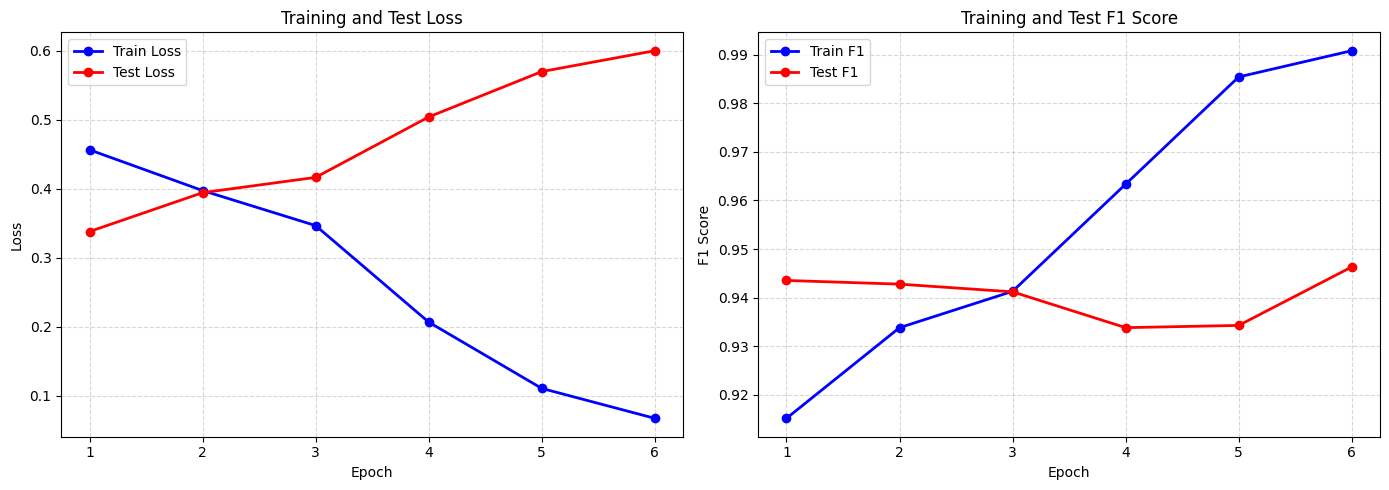

✅ Chart saved as stance_samplemodel_MT2_Bert_E6_B4.pt_charts.png

Confusion Matrix:
[[  2  15]
 [  1 141]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.12      0.20        17
           1       0.90      0.99      0.95       142

    accuracy                           0.90       159
   macro avg       0.79      0.56      0.57       159
weighted avg       0.88      0.90      0.87       159

✅ Evaluation report saved as stance_samplemodel_MT2_Bert_E6_B4.pt_eval.txt


In [30]:
plot_training_history_cm_cr(history2, y_true=y_test2,y_pred=y_test2_pred, classes=["0", "1"], run_name='stance_samplemodel_MT2_Bert_E6_B4.pt')


# IBM

In [6]:
X_train3, X_test3, y_train3, y_test3 = preprocess_data(dfIBM, use_nrc=True, include_topic=True, sample_level= True, test_size=0.2,random_state=41,)

In [88]:
X_train3_n, X_test3_n, y_train3_n, y_test3_n = preprocess_data(dfIBM, use_nrc=  False, include_topic=True, sample_level= False, test_size=0.2,random_state=41,)

In [89]:
model3_n, history3_n, y_test3_pred_n = train_model(
    X_train=(X_train3_n['text'].tolist(), X_train3_n['topic_id'].tolist()),
    y_train=y_train3_n.tolist(),
    X_test=(X_test3_n['text'].tolist(), X_test3_n['topic_id'].tolist()),
    y_test=y_test3_n.tolist(),
    batch_size=4,
    epochs=6,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=False,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='./models/stance_model_IBM_Bert_E6_B4_N_Not_NRC.pt'
    )




h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/6: 100%|██████████| 479/479 [43:16<00:00,  5.42s/it]



Epoch 1/6
Train Loss: 0.6875, Train F1: 0.5061
Test Loss: 0.6506, F1: 0.6102, Precision: 0.6346, Recall: 0.6150
--------------------------------------------------


Epoch 2/6: 100%|██████████| 479/479 [43:08<00:00,  5.40s/it]



Epoch 2/6
Train Loss: 0.5914, Train F1: 0.6927
Test Loss: 0.6542, F1: 0.6793, Precision: 0.6792, Recall: 0.6795
--------------------------------------------------


Epoch 3/6: 100%|██████████| 479/479 [42:54<00:00,  5.38s/it]



Epoch 3/6
Train Loss: 0.4560, Train F1: 0.8645
Test Loss: 1.0560, F1: 0.6667, Precision: 0.6665, Recall: 0.6668
--------------------------------------------------


Epoch 4/6: 100%|██████████| 479/479 [42:43<00:00,  5.35s/it]



Epoch 4/6
Train Loss: 0.2512, Train F1: 0.9418
Test Loss: 1.6256, F1: 0.6676, Precision: 0.6731, Recall: 0.6666
--------------------------------------------------


Epoch 5/6: 100%|██████████| 479/479 [42:18<00:00,  5.30s/it]



Epoch 5/6
Train Loss: 0.1457, Train F1: 0.9725
Test Loss: 1.7314, F1: 0.6822, Precision: 0.6968, Recall: 0.6814
--------------------------------------------------


Epoch 6/6: 100%|██████████| 479/479 [42:09<00:00,  5.28s/it]



Epoch 6/6
Train Loss: 0.0723, Train F1: 0.9847
Test Loss: 1.9132, F1: 0.7050, Precision: 0.7065, Recall: 0.7088
--------------------------------------------------
✅ Model saved to: ./models/stance_model_IBM_Bert_E6_B4_N_Not_NRC.pt


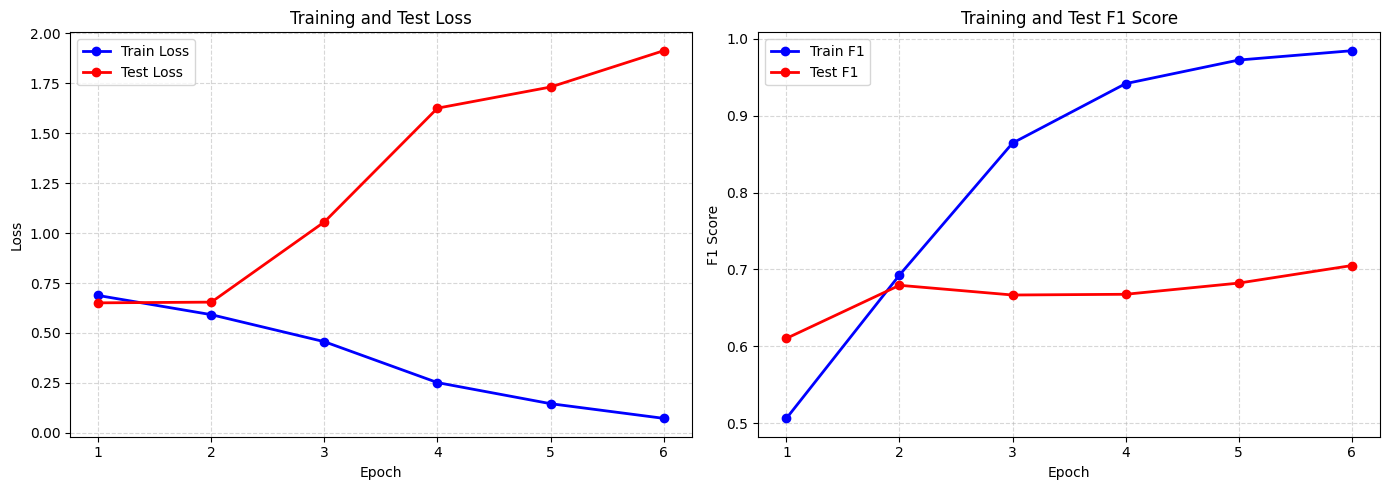

✅ Chart saved as ./plots/IBM_Bert_E6_B4_Not_NRC_charts.png

Confusion Matrix:
[[158  56]
 [ 85 180]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.74      0.69       214
           1       0.76      0.68      0.72       265

    accuracy                           0.71       479
   macro avg       0.71      0.71      0.71       479
weighted avg       0.71      0.71      0.71       479

✅ Evaluation report saved as ./plots/IBM_Bert_E6_B4_Not_NRC_eval.txt


In [90]:
plot_training_history_cm_cr(history3_n, y_true=y_test3_n, y_pred=y_test3_pred_n, run_name="./plots/IBM_Bert_E6_B4_Not_NRC")


In [41]:
model3, history3, y_test3_pred= train_model(
    X_train=(X_train3['text'].tolist(), X_train3['topic_id'].tolist(), X_train3['nrc_feats'].tolist()),
    y_train=y_train3.tolist(),
    X_test=(X_test3['text'].tolist(), X_test3['topic_id'].tolist(), X_test3['nrc_feats'].tolist()),
    y_test=y_test3.tolist(),
    batch_size=4,
    epochs=6,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=True,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='stance_model_sampleIBM_Bert_E6_B4.pt'
)


h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/6: 100%|██████████| 460/460 [16:32<00:00,  2.16s/it]


Epoch 1/6
Train loss: 0.6776
Train F1: 0.6869
Test loss: 0.7132
Test F1: 0.4215, Precision: 0.7176, Recall: 0.2984
--------------------------------------------------


Epoch 2/6: 100%|██████████| 460/460 [16:22<00:00,  2.14s/it]


Epoch 2/6
Train loss: 0.5838
Train F1: 0.7368
Test loss: 0.8832
Test F1: 0.5242, Precision: 0.6323, Recall: 0.4476
--------------------------------------------------


Epoch 3/6: 100%|██████████| 460/460 [16:23<00:00,  2.14s/it]


Epoch 3/6
Train loss: 0.4577
Train F1: 0.8640
Test loss: 1.5169
Test F1: 0.5590, Precision: 0.6169, Recall: 0.5111
--------------------------------------------------


Epoch 4/6: 100%|██████████| 460/460 [16:20<00:00,  2.13s/it]


Epoch 4/6
Train loss: 0.2432
Train F1: 0.9446
Test loss: 2.0732
Test F1: 0.5660, Precision: 0.6157, Recall: 0.5238
--------------------------------------------------


Epoch 5/6: 100%|██████████| 460/460 [16:23<00:00,  2.14s/it]


Epoch 5/6
Train loss: 0.1256
Train F1: 0.9767
Test loss: 2.3526
Test F1: 0.4944, Precision: 0.5964, Recall: 0.4222
--------------------------------------------------


Epoch 6/6: 100%|██████████| 460/460 [16:23<00:00,  2.14s/it]


Epoch 6/6
Train loss: 0.0920
Train F1: 0.9832
Test loss: 2.9549
Test F1: 0.5308, Precision: 0.5945, Recall: 0.4794
--------------------------------------------------
✅ Model saved to: stance_model_sampleIBM_Bert_E6_B4.pt


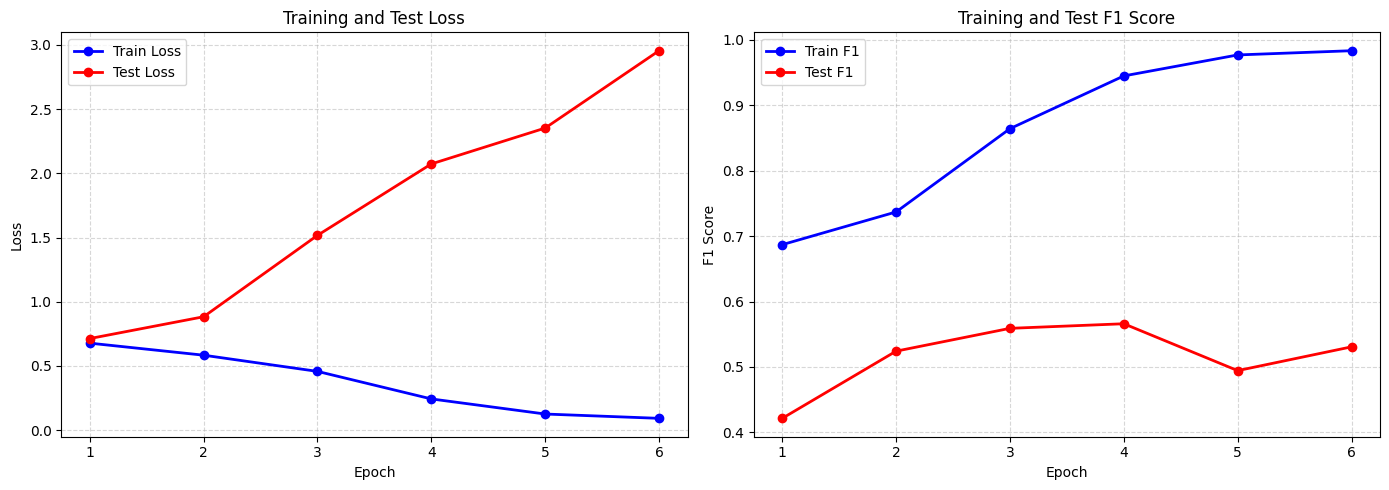

✅ Chart saved as stance_samplemodel_IBM_Bert_E6_B4.pt_charts.png

Confusion Matrix:
[[139 103]
 [164 151]]

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.57      0.51       242
           1       0.59      0.48      0.53       315

    accuracy                           0.52       557
   macro avg       0.53      0.53      0.52       557
weighted avg       0.54      0.52      0.52       557

✅ Evaluation report saved as stance_samplemodel_IBM_Bert_E6_B4.pt_eval.txt


In [42]:
plot_training_history_cm_cr(history3, y_true=y_test3,y_pred=y_test3_pred, classes=["0", "1"], run_name='stance_samplemodel_IBM_Bert_E6_B4.pt')


# Optimization

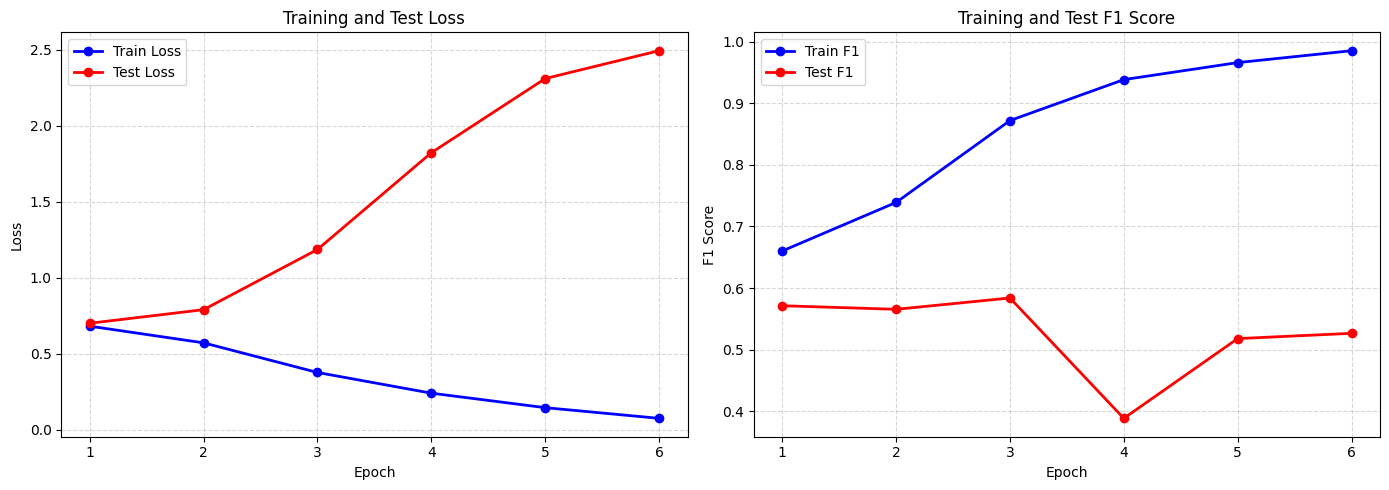

✅ Chart saved as stance_samplemodel_IBM_Bert_E6_B8.pt_charts.png

Confusion Matrix:
[[143  99]
 [167 148]]

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.59      0.52       242
           1       0.60      0.47      0.53       315

    accuracy                           0.52       557
   macro avg       0.53      0.53      0.52       557
weighted avg       0.54      0.52      0.52       557

✅ Evaluation report saved as stance_samplemodel_IBM_Bert_E6_B8.pt_eval.txt


In [45]:
plot_training_history_cm_cr(history3a, y_true=y_test3, y_pred=y_test3a_pred, classes=["0", "1"], run_name='stance_samplemodel_IBM_Bert_E6_B8.pt')


# Error Analysis of IBM

In [10]:
pwd

'h:\\moha\\NLP\\AM\\SA\\ArguSentiment\\src'

In [17]:
# Define file path
file_path = 'models/stance_model_IBM_Bert_E6_B4_N.pt'

# Instantiate the model (it needs to be defined of course)
model = model = torch.load(file_path, weights_only=False)




In [18]:
model

OrderedDict([('bert.embeddings.word_embeddings.weight',
              tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098],
                      [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
                      [-0.0198, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
                      ...,
                      [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
                      [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
                      [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]])),
             ('bert.embeddings.position_embeddings.weight',
              tensor([[ 1.8166e-02, -2.6040e-02, -3.6269e-02,  ..., -8.2666e-06,
                       -9.8493e-04,  1.5863e-02],
                      [ 7.4719e-03,  2.6112e-03, -1.9932e-02,  ...,  2.7890e-02,
                        2.9120e-02, -5.9432e-03],
                      [-1.1512e-02, -1.9101e-03, -1.1518e-02,  ...,  1.3690e-02,
       

In [ ]:
if y_true is not None and y_pred is not None:
        y_true_flat = flatten_if_nested(y_true)
        y_pred_flat = flatten_if_nested(y_pred)

        y_true_flat = np.array(y_true_flat)
        y_pred_flat = np.array(y_pred_flat)

        cm = confusion_matrix(y_true_flat, y_pred_flat)
        cr = classification_report(y_true_flat, y_pred_flat, target_names=classes) if classes else classification_report(y_true_flat, y_pred_flat)

        print("\nConfusion Matrix:")
        print(cm)
        print("\nClassification Report:")
        print(cr)

        with open(f"{run_name}_eval.txt", "w") as f:
            f.write("Confusion Matrix:\n")
            f.write(np.array2string(cm))
            f.write("\n\nClassification Report:\n")
            f.write(cr)

        print(f"✅ Evaluation report saved as {run_name}_eval.txt")


In [ ]:
plot_training_history_cm_cr(history3, y_true=y_test3,y_pred=y_test3_pred, classes=["0", "1"], run_name='stance_samplemodel_IBM_Bert_E6_B4.pt')


# PE

In [95]:
dfPC['stance'] = dfPC['stance'].apply(
    lambda stance_list: ['Neutral' if s is None else s for s in stance_list]
)

In [112]:
X_train4, X_test4, y_train4, y_test4 = preprocess_data(dfPC, use_nrc=True, include_topic=True, sample_level= True, test_size=0.2,random_state=41)

In [113]:
X_train4_n, X_test4_n, y_train4_n, y_test4_n = preprocess_data(dfPC, use_nrc=True, include_topic=True, sample_level= False, test_size=0.2,random_state=41,)

In [106]:
print("Unique labels overall:", sorted(set(y_test4_n)))

Unique labels overall: [0, 1, 2]


In [107]:
print("Unique labels overall:", sorted(set(y_train4_n)))

Unique labels overall: [0, 1, 2]


In [14]:
model4, history4, y_test4_pred= train_model(
    X_train=(X_train4['text'].tolist(), X_train4['topic_id'].tolist(), X_train4['nrc_feats'].tolist()),
    y_train=y_train4.tolist(),
    X_test=(X_test4['text'].tolist(), X_test4['topic_id'].tolist(), X_test4['nrc_feats'].tolist()),
    y_test=y_test4.tolist(),
    batch_size=4,
    epochs=6,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=True,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='./models/stance_model_samplePE_Bert_E6_B4_new.pt'
)


h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/6: 100%|██████████| 1218/1218 [1:23:22<00:00,  4.11s/it]



Epoch 1/6
Train Loss: 0.6916, Train F1: 0.2882
Test Loss: 0.6757, F1: 0.2852, Precision: 0.2492, Recall: 0.3333
--------------------------------------------------


Epoch 2/6: 100%|██████████| 1218/1218 [54:05<00:00,  2.66s/it] 



Epoch 2/6
Train Loss: 0.6820, Train F1: 0.2988
Test Loss: 0.6595, F1: 0.3767, Precision: 0.4022, Recall: 0.3811
--------------------------------------------------


Epoch 3/6: 100%|██████████| 1218/1218 [53:56<00:00,  2.66s/it]



Epoch 3/6
Train Loss: 0.6276, Train F1: 0.4464
Test Loss: 0.7648, F1: 0.3849, Precision: 0.3891, Recall: 0.3886
--------------------------------------------------


Epoch 4/6: 100%|██████████| 1218/1218 [48:59<00:00,  2.41s/it]



Epoch 4/6
Train Loss: 0.5035, Train F1: 0.5853
Test Loss: 1.2694, F1: 0.4310, Precision: 0.6530, Recall: 0.4111
--------------------------------------------------


Epoch 5/6: 100%|██████████| 1218/1218 [40:53<00:00,  2.01s/it]



Epoch 5/6
Train Loss: 0.3770, Train F1: 0.7226
Test Loss: 1.5386, F1: 0.4413, Precision: 0.5075, Recall: 0.4229
--------------------------------------------------


Epoch 6/6: 100%|██████████| 1218/1218 [40:43<00:00,  2.01s/it]



Epoch 6/6
Train Loss: 0.2791, Train F1: 0.8110
Test Loss: 1.6419, F1: 0.4535, Precision: 0.4835, Recall: 0.4398
--------------------------------------------------
✅ Model saved to: ./models/stance_model_samplePE_Bert_E6_B4_new.pt


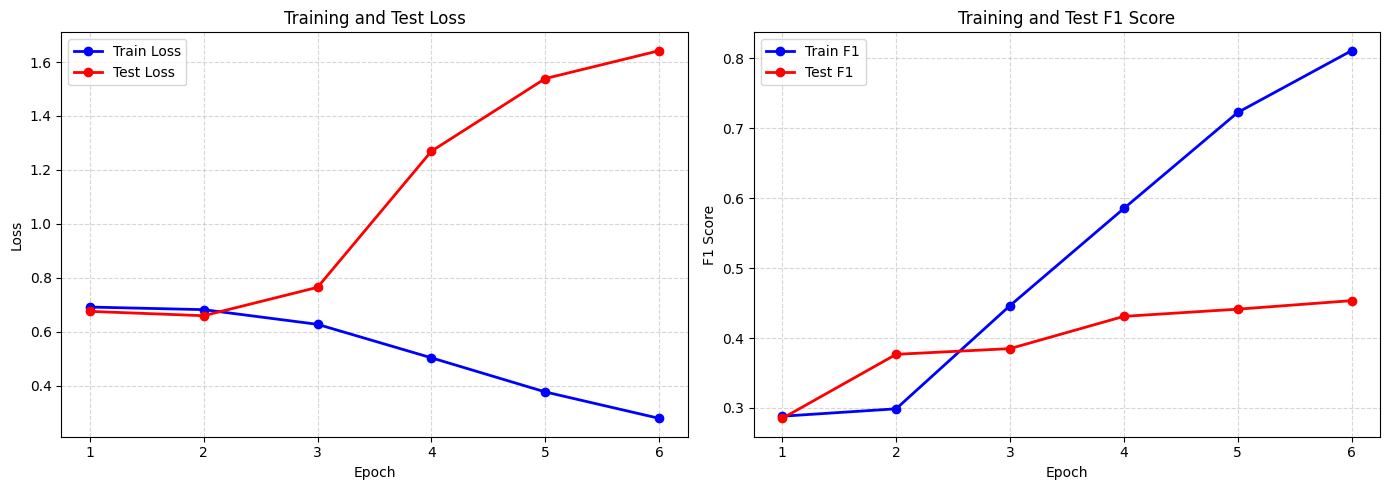

✅ Chart saved as ./results/stance_model_samplePE_Bert_E6_B4_new.pt.pt_charts.png

Confusion Matrix:
[[  9   6  32]
 [  9  66 186]
 [ 14 100 798]]

Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.19      0.23        47
           1       0.38      0.25      0.30       261
           2       0.79      0.88      0.83       912

    accuracy                           0.72      1220
   macro avg       0.48      0.44      0.45      1220
weighted avg       0.68      0.72      0.69      1220

✅ Evaluation report saved as ./results/stance_model_samplePE_Bert_E6_B4_new.pt.pt_eval.txt


In [ ]:
plot_training_history_cm_cr(history4, y_true=y_test4, y_pred=y_test4_pred, classes=["0", "1", "2"], run_name='./results/stance_model_samplePE_Bert_E6_B4_new.pt')


In [117]:
model4_n, history4_n, y_test4_pred_n = train_model(
    X_train=(X_train4_n['text'].tolist(), X_train4_n['topic_id'].tolist()),
    y_train=y_train4_n.tolist(),
    X_test=(X_test4_n['text'].tolist(), X_test4_n['topic_id'].tolist()),
    y_test=y_test4_n.tolist(),
    batch_size=4,
    epochs=6,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=False,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='./models/stance_model_PE_Bert_E6_B4_N_new.pt'
    )




h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/6: 100%|██████████| 1218/1218 [1:02:42<00:00,  3.09s/it]



Epoch 1/6
Train Loss: 0.6869, Train F1: 0.2859
Test Loss: 0.6592, F1: 0.2847, Precision: 0.2485, Recall: 0.3333
--------------------------------------------------


Epoch 2/6: 100%|██████████| 1218/1218 [1:26:40<00:00,  4.27s/it] 



Epoch 2/6
Train Loss: 0.6400, Train F1: 0.4096
Test Loss: 0.6661, F1: 0.3452, Precision: 0.3985, Recall: 0.3602
--------------------------------------------------


Epoch 3/6: 100%|██████████| 1218/1218 [44:38<00:00,  2.20s/it]



Epoch 3/6
Train Loss: 0.4952, Train F1: 0.6024
Test Loss: 1.1611, F1: 0.4056, Precision: 0.4581, Recall: 0.3970
--------------------------------------------------


Epoch 4/6: 100%|██████████| 1218/1218 [42:34<00:00,  2.10s/it]



Epoch 4/6
Train Loss: 0.3712, Train F1: 0.7101
Test Loss: 1.4432, F1: 0.4119, Precision: 0.4636, Recall: 0.4057
--------------------------------------------------


Epoch 5/6: 100%|██████████| 1218/1218 [42:19<00:00,  2.08s/it]



Epoch 5/6
Train Loss: 0.2735, Train F1: 0.7942
Test Loss: 1.8357, F1: 0.4025, Precision: 0.4162, Recall: 0.3975
--------------------------------------------------


Epoch 6/6: 100%|██████████| 1218/1218 [42:28<00:00,  2.09s/it]



Epoch 6/6
Train Loss: 0.2119, Train F1: 0.8477
Test Loss: 2.0115, F1: 0.3945, Precision: 0.4078, Recall: 0.3901
--------------------------------------------------
✅ Model saved to: ./models/stance_model_PE_Bert_E6_B4_N_new.pt


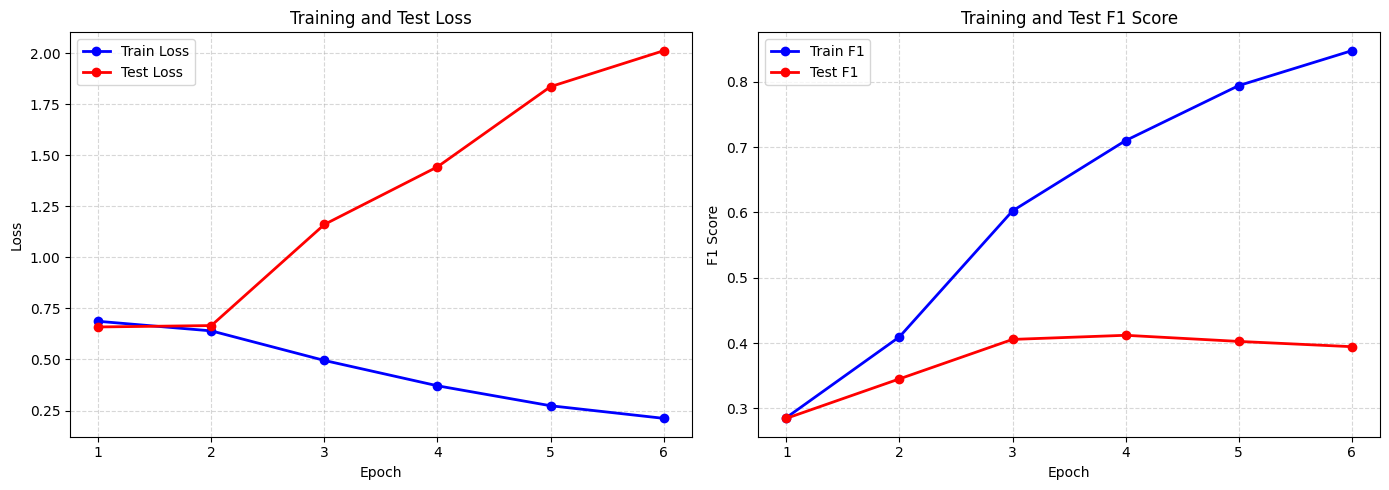

✅ Chart saved as ./results/stance_model_PE_Bert_E6_B4_N_new.pt_charts.png

Confusion Matrix:
[[  3   9  44]
 [ 15  66 173]
 [ 32  98 778]]

Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.05      0.06        56
           1       0.38      0.26      0.31       254
           2       0.78      0.86      0.82       908

    accuracy                           0.70      1218
   macro avg       0.41      0.39      0.39      1218
weighted avg       0.67      0.70      0.68      1218

✅ Evaluation report saved as ./results/stance_model_PE_Bert_E6_B4_N_new.pt_eval.txt


In [119]:
plot_training_history_cm_cr(history4_n, y_true=y_test4_n, y_pred=y_test4_pred_n, classes=["0", "1", "2"], run_name='./results/stance_model_PE_Bert_E6_B4_N_new.pt')


# UKP

In [62]:
dfUKB['stance'] = dfUKB['stance'].apply(
    lambda stance_list: ['Neutral' if s is None else s for s in stance_list]
)

In [77]:
X_train5, X_test5, y_train5, y_test5 = preprocess_data(dfUKB, use_nrc=True, include_topic=True, sample_level= True, test_size=0.2,random_state=41)

In [78]:
X_train5_n, X_test5_n, y_train5_n, y_test5_n = preprocess_data(dfUKB, use_nrc=True, include_topic=True, sample_level= False, test_size=0.2,random_state=41,)

In [83]:
model5, history5, y_test5_pred= train_model(
    X_train=(X_train5['text'].tolist(), X_train5['topic_id'].tolist(), X_train5['nrc_feats'].tolist()),
    y_train=y_train5.tolist(),
    X_test=(X_test5['text'].tolist(), X_test5['topic_id'].tolist(), X_test5['nrc_feats'].tolist()),
    y_test=y_test5.tolist(),
    batch_size=4,
    epochs=6,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=True,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='./models/stance_model_sampleukb_Bert_E6_B4.pt'
)


h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/6: 100%|██████████| 4841/4841 [6:46:45<00:00,  5.04s/it]  



Epoch 1/6
Train Loss: 0.7681, Train F1: 0.5767
Test Loss: 0.7806, F1: 0.5354, Precision: 0.6550, Recall: 0.5159
--------------------------------------------------


Epoch 2/6: 100%|██████████| 4841/4841 [6:31:21<00:00,  4.85s/it]  



Epoch 2/6
Train Loss: 0.6081, Train F1: 0.7414
Test Loss: 1.7508, F1: 0.4538, Precision: 0.6327, Recall: 0.4503
--------------------------------------------------


Epoch 3/6: 100%|██████████| 4841/4841 [6:39:57<00:00,  4.96s/it]  



Epoch 3/6
Train Loss: 0.4829, Train F1: 0.8397
Test Loss: 2.3007, F1: 0.4287, Precision: 0.5988, Recall: 0.4311
--------------------------------------------------


Epoch 4/6: 100%|██████████| 4841/4841 [7:18:17<00:00,  5.43s/it]   



Epoch 4/6
Train Loss: 0.3774, Train F1: 0.8917
Test Loss: 2.4205, F1: 0.3997, Precision: 0.6394, Recall: 0.4144
--------------------------------------------------


Epoch 5/6: 100%|██████████| 4841/4841 [6:52:22<00:00,  5.11s/it]  



Epoch 5/6
Train Loss: 0.2924, Train F1: 0.9256
Test Loss: 2.2837, F1: 0.4645, Precision: 0.5964, Recall: 0.4569
--------------------------------------------------


Epoch 6/6: 100%|██████████| 4841/4841 [6:41:07<00:00,  4.97s/it]  



Epoch 6/6
Train Loss: 0.2171, Train F1: 0.9466
Test Loss: 2.7567, F1: 0.4618, Precision: 0.5739, Recall: 0.4551
--------------------------------------------------
✅ Model saved to: ./models/stance_model_sampleukb_Bert_E6_B4.pt


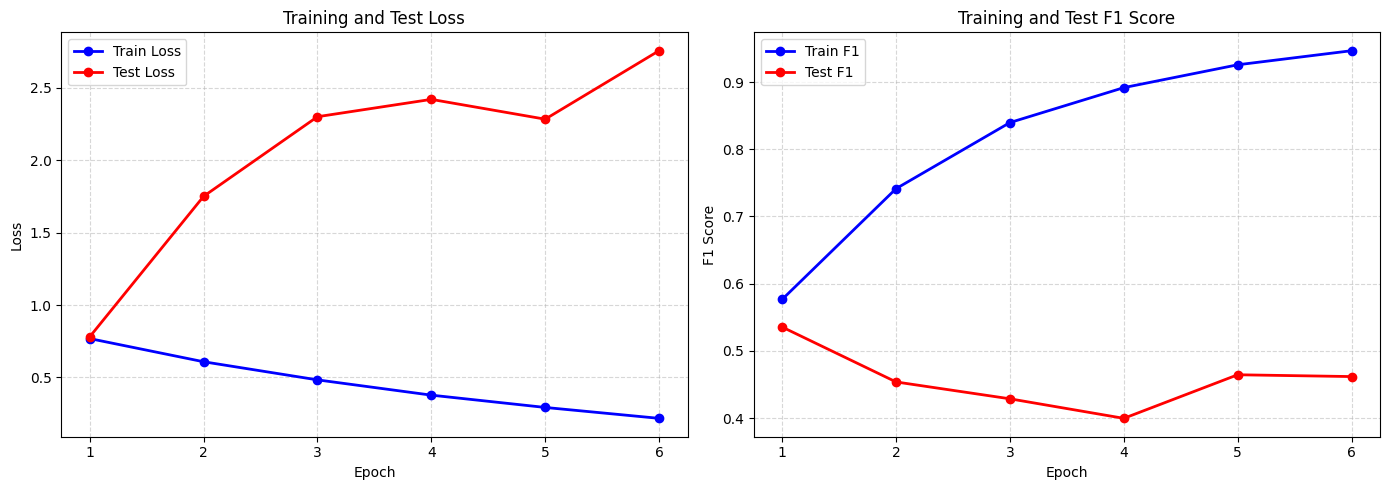

✅ Chart saved as ./results/stance_model_sampleUKB_Bert_E6_B4.pt_charts.png

Confusion Matrix:
[[ 385   87  931]
 [ 106  213  863]
 [ 212   97 3155]]

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.27      0.37      1403
           1       0.54      0.18      0.27      1182
           2       0.64      0.91      0.75      3464

    accuracy                           0.62      6049
   macro avg       0.57      0.46      0.46      6049
weighted avg       0.60      0.62      0.57      6049

✅ Evaluation report saved as ./results/stance_model_sampleUKB_Bert_E6_B4.pt_eval.txt


In [84]:
plot_training_history_cm_cr(history5, y_true=y_test5, y_pred=y_test5_pred, classes=["0", "1", "2"], run_name='./results/stance_model_sampleUKB_Bert_E6_B4.pt')
